In [1]:
%reset -f

In [17]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os
import pickle

import numpy as np
import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import LSTM, GRU
from keras.layers.wrappers import TimeDistributed
from keras import regularizers
from keras.optimizers import *

import sklearn as skl
from sklearn import base
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
# 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5.0, 4.0)

sys.path.append("../utils/")
from plot_style import *

sys.path.append("util")
from training_tool import *
from vis_tool import *
from data_manipulation_tool import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

## Read Data

In [3]:
# def read_data(machine_id, frac, set_id, data_type, data_dir):
#     """
#     machine_id: 1 ~ 4
#     set_id: 0 ~ 4
#     frac:  1, 5, 10, 20, 50, 80, 90, 100
    
#     """
    
#     data_file = data_dir + '/FD{:03d}/frac{}/{}_FD{:03d}_proc2_set{}.csv'.format(machine_id, frac, data_type, machine_id, set_id)
#     df = pd.read_csv(data_file)

#     X = df[[str(i) for i in range(17)]].values
#     y = df['RUL'].values.astype('float')
#     uid = df['RunID'].values
        
#     return X, y, uid

## Recast Data

In [4]:
# def recast_matrix(X, y, lag):
#     n_rows = X.shape[0]
#     n_instances = n_rows - lag + 1
    
#     X_out, y_out = X[:n_instances, :], y[lag-1:]
#     for w in range(1, lag):
#         Xw = X[w:w+n_instances, :]
#         X_out = np.hstack((X_out, Xw))
    
#     return X_out, y_out

# def recast_data(X, y, lag, win_size, uid, data_type):    
#     X_out = np.zeros((0, win_size, lag*X.shape[1]))
#     y_out = np.zeros(0)
#     for i in np.unique(uid):
#         ind = uid == i
#         Xi, yi = recast_matrix(X[ind, :], y[ind], lag)
#         Xii, yii = recast_matrix(Xi, yi, win_size)
        
#         Xii = Xii.reshape(-1, win_size, lag*X.shape[1])
        
#         if data_type == 'train':
#             X_out = np.concatenate([X_out, Xii])
#             y_out = np.append(y_out, yii)
#         elif data_type == 'test':
#             X_out = np.concatenate([X_out, Xii[[-1], :, :]])
#             y_out = np.append(y_out, yii[-1])
#         else:
#             raise Exception('In recast_data, data_type should be one of {train, test}')
        
#     return X_out, y_out

## Evaluate

In [5]:
# def evaluate(y_true, y_pred, classification):
#     if classification:
#         acc = accuracy_score(y_true, y_pred)
#         pre, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', pos_label=1)

#         cfs_mat = confusion_matrix(y_true, y_pred)
#         fpr = 1.0 * cfs_mat[0,1] / np.sum(cfs_mat[0,:])

#         return {'acc': acc, 'pre': pre, 'rec': rec, 'f1': f1, 'fpr': fpr}
#     else:
#         def asym_loss(y_true, y_pred):
#             d_all = y_pred.reshape(-1) - y_true.reshape(-1)

#             coef = np.zeros_like(d_all)
#             coef[d_all < 0] = -1.0/10
#             coef[d_all >= 0] = 1.0/13

#             return np.sum(np.exp(d_all * coef) - 1)
        
#         mse = np.mean((y_true - y_pred)**2)
#         rmse = np.sqrt(mse)
#         cos_sim = cosine_similarity(y_true.reshape(1,-1), y_pred.reshape(1,-1))[0,0]
#         pcc = pearsonr(y_true, y_pred)[0]
#         asym = asym_loss(y_true, y_pred)
            
#         return {'mse': mse, 'rmse': rmse, 'cos_sim': cos_sim, 'pcc': pcc, 'asym': asym}
    
# def eval_as_array(evals, metric_order):
#     eval_array = []
#     for eval_map in evals:
#         eval_array.append([eval_map[metric] for metric in metric_order])
#     return np.array(eval_array)

# def eval_as_dataframe(evals, model_names, metric_order):
#     eval_arr = eval_as_array(evals, metric_order)
#     eval_df = pd.DataFrame(eval_arr, index=model_names, columns=metric_order)
#     return eval_df

## Test Various Settings

In [6]:
# class Runner:
#     def __init__(self, X_train, y_train, X_test, y_test):
#         self.X_train = X_train
#         self.y_train = y_train
#         self.X_test = X_test
#         self.y_test = y_test
        
#     def __call__(self, submission, return_train_pred=False, return_test_pred=False):
#         train_pred, test_pred = [], []
#         eval_trn, eval_tst = [], []
#         for i, (model, param) in enumerate(submission):
#             model.fit(self.X_train, self.y_train, **param)

#             y_train_pred = model.predict(self.X_train).reshape(-1)
#             y_test_pred = model.predict(self.X_test).reshape(-1)

#             ev_trn = evaluate(self.y_train, y_train_pred, classification=False)
#             ev_tst = evaluate(self.y_test, y_test_pred, classification=False)

#             eval_trn.append(ev_trn)
#             eval_tst.append(ev_tst)
            
#             train_pred.append(y_train_pred)
#             test_pred.append(y_test_pred)
        
#         return_tuple = [np.array(eval_trn), np.array(eval_tst)]
#         if return_train_pred:
#             return_tuple.append(np.array(train_pred).T)
#         if return_test_pred:
#             return_tuple.append(np.array(test_pred).T)
        
#         return tuple(return_tuple)

## Visualize

In [7]:
# def vis_by_bar(vals, model_names=None, metric_names=None, **bar_param):
#     """
#     Rows of vals correspond to models
#     Columns of vals correspond to metrics
#     """
#     if type(vals) is not pd.DataFrame:
#         eval_df = pd.DataFrame(vals, index=model_names, columns=['mse', 'asym'])
#     else:
#         eval_df = vals
        
#     eval_df.plot.bar(**bar_param)

# def vis_by_scatter(y_true_list, y_pred_list, model_name_list, vals, grid_size, margins=(0.5,0.5), fig_size=(14,8)):
#     _, axes = plt.subplots(*grid_size)
#     plt.subplots_adjust(wspace=margins[0], hspace=margins[1])
    
#     n_prev_plots = 0
#     for k, model_names in enumerate(model_name_list):
#         y_true = y_true_list[k]
#         n_instances = y_true_list[k].shape[0]
#         for i, model_name in enumerate(model_names):
#             y_pred = y_pred_list[k][:, i]

#             lim = np.min(y_true), np.max(y_true)

#             # perfect line
#             ax = axes.flatten()[n_prev_plots + i]
#             ax.plot(lim, lim, '-', color='#444444', linewidth=1, label='perfect')
#             ax.margins(x=0.05, y=0.05, tight=False)

#             # error line
#             guide_mses = [100, 500]
#             guide_mse_styles = ['--', ':']
#             for g, ls in zip(guide_mses, guide_mse_styles):
#                 ax.plot(lim, lim + np.sqrt(g)/n_instances, linestyle=ls, color='#444444', linewidth=1, label='MSE {}'.format(g))
#                 ax.plot(lim, lim - np.sqrt(g)/n_instances, linestyle=ls, color='#444444', linewidth=1)

#             # true vs. pred
#             vs_df = pd.DataFrame(np.array([y_true,y_pred]).T, columns=['Truth', 'Predicted'])
#             vs_df.plot.scatter(x='Truth', y='Predicted', ax=ax, figsize=fig_size, c='#FF5555', title=model_name)

# #             ax.legend(prop={'size':12})
#             text_list = [metric + ': {:.2f}'.format(vals[k].iloc[i][metric]) for metric in vals[k].columns.values]
#             xpos = ax.get_xlim()[0] + 0.05*(ax.get_xlim()[1] - ax.get_xlim()[0])
#             ypos = ax.get_ylim()[0] + 0.95*(ax.get_ylim()[1] - ax.get_ylim()[0])
#             ax.text(xpos, ypos, s='\n'.join(text_list), 
#                    ha='left', va='top')
            
#         n_prev_plots += len(model_names)

---

# Main Script

## Read and Summarize Data

In [8]:
# do_print = True

data_dir = '/local/Data/MLforPHM17/cmapss/proc2'
machine_id = 1

#####
# set_id = 0
# frac = 100
trunc_y = True
homo_ens = True
# do_print = True
#####

X_train_raw, y_train_raw, train_uid = read_data(machine_id, frac, set_id, 'train', data_dir)
X_test_raw, y_test_raw, test_uid = read_data(machine_id, frac, set_id, 'test', data_dir)

if trunc_y:
    y_train_raw[y_train_raw > 140] = 140

if do_print:
    print 'Machine ID: ', machine_id
    print 'Fraction: ', frac/100.0
    print 'Dataset ID: ', set_id
    print ''
    print 'Shape of X_train_raw, y_train_raw: ', X_train_raw.shape, y_train_raw.shape
    print 'Shape of X_test_raw, y_test_raw: ', X_test_raw.shape, y_test_raw.shape
    print 'Train Units: ', np.unique(train_uid)
    print 'Test Units: ', np.unique(test_uid)

    print '\n'
    print 'Maximum window size for each lag:'
    n_min_units = np.sort(np.bincount(test_uid))[1]
    print pd.DataFrame([(i,n_min_units-i+1) for i in range(1,11)], columns=['lag', 'win_size'])

Machine ID:  1
Fraction:  1.0
Dataset ID:  0

Shape of X_train_raw, y_train_raw:  (20631, 17) (20631,)
Shape of X_test_raw, y_test_raw:  (13096, 17) (13096,)
Train Units:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]
Test Units:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]



## Recast Data Depending on Model

In [9]:
# lag = 10
# win_size = 10

# lag = 20
# win_size = 5

lag = 5
win_size = 1

# lag = 3
# win_size = 10

recast_file_path = 'data/recast/mid{}_fr{}_set{}_lag{}_win{}_ytr{}.dump'.format(machine_id, frac, set_id, lag, win_size, int(trunc_y))
var_list_str = 'mlp_X_train, mlp_y_train, mlp_X_test, mlp_y_test, rf_X_train, rf_y_train, rf_X_test, rf_y_test'
if os.path.isfile(recast_file_path):
    with open(recast_file_path,'r') as f:
        exec('{} = pickle.load(f)'.format(var_list_str))
else:
    mlp_X_train, mlp_y_train = recast_data(X_train_raw, y_train_raw, lag, win_size, train_uid, 'train')
    mlp_X_test, mlp_y_test = recast_data(X_test_raw, y_test_raw, lag, win_size, test_uid, 'test')

    rf_X_train, rf_y_train = recast_data(X_train_raw, y_train_raw, lag, 1, train_uid, 'train')
    rf_X_test, rf_y_test = recast_data(X_test_raw, y_test_raw, lag, 1, test_uid, 'test')

    rf_X_train = rf_X_train.reshape(rf_X_train.shape[0], rf_X_train.shape[2])
    rf_X_test = rf_X_test.reshape(rf_X_test.shape[0], rf_X_test.shape[2])
    
    with open(recast_file_path,'w+') as f:
        eval('pickle.dump(file=f, obj=({}))'.format(var_list_str))

if do_print:
    print 'Shape of mlp_X_train: ', mlp_X_train.shape
    print 'Shape of mlp_y_train: ', mlp_y_train.shape
    print 'Shape of mlp_X_test: ', mlp_X_test.shape
    print 'Shape of mlp_y_test: ', mlp_y_test.shape

    print ''
    print 'Shape of rf_X_train: ', rf_X_train.shape
    print 'Shape of rf_y_train: ', rf_y_train.shape
    print 'Shape of rf_X_test: ', rf_X_test.shape
    print 'Shape of rf_y_test: ', rf_y_test.shape

Shape of mlp_X_train:  (18331, 20, 85)
Shape of mlp_y_train:  (18331,)
Shape of mlp_X_test:  (100, 20, 85)
Shape of mlp_y_test:  (100,)

Shape of rf_X_train:  (20231, 85)
Shape of rf_y_train:  (20231,)
Shape of rf_X_test:  (100, 85)
Shape of rf_y_test:  (100,)


## Define Template to Create MLP Object

In [10]:
def get_mlp(input_shape, td_hidden_dims, hidden_dims, reg_weight):    
    model = Sequential()
    
    dense_in = Dense(td_hidden_dims[0], activation='relu',
                     kernel_initializer='normal', 
                     kernel_regularizer=regularizers.l2(reg_weight))    
    model.add(TimeDistributed(dense_in, input_shape=input_shape))
#     model.add(BatchNormalization())
    
    for h_dim in td_hidden_dims[1:]:
        dense_td = Dense(h_dim, activation='relu', 
                         kernel_initializer='normal', 
                         kernel_regularizer=regularizers.l2(reg_weight))
        model.add(TimeDistributed(dense_td))
#         model.add(BatchNormalization())
        
    model.add(Flatten())
    
    for h_dim in hidden_dims:
        dense_hd = Dense(h_dim, activation='relu', 
                         kernel_initializer='normal', 
                         kernel_regularizer=regularizers.l2(reg_weight))
        model.add(dense_hd)
#         model.add(BatchNormalization())
        
    dense_out = Dense(1, activation='linear', 
                      kernel_initializer='normal',
                      kernel_regularizer=regularizers.l2(reg_weight))
    model.add(dense_out)
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))
    
    return model

if do_print:
    model_example_in_str = 'get_mlp(input_shape=[10, 2], td_hidden_dims=[12, 8], hidden_dims=[4], reg_weight=0.01)'
    print 'Usage of get_mlp:', model_example_in_str, 'returns the model of'
    eval(model_example_in_str).summary()

Usage of get_mlp: get_mlp(input_shape=[10, 2], td_hidden_dims=[12, 8], hidden_dims=[4], reg_weight=0.01) returns the model of
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 12)            36        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 8)             104       
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 324       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 469.0
Trainable params: 469.0
Non-trainable params: 0.0
_________________________________________________________________


## Create Objects to Be Evaluated
Two classes of models, Random Forest and Multi-layter Perceptron, are considered

In [11]:
data_dim = rf_X_train.shape[1]
half_dim = data_dim / 2

rf_copier = lambda rf: base.clone(rf)
rf_submission = [
    (RandomForestRegressor(n_estimators=10, max_features=data_dim, max_depth=10, n_jobs=12), rf_copier, {}),
    (RandomForestRegressor(n_estimators=20, max_features=data_dim, max_depth=10, n_jobs=12), rf_copier, {}),
    (RandomForestRegressor(n_estimators=40, max_features=data_dim, max_depth=10, n_jobs=12), rf_copier, {}),
    (RandomForestRegressor(n_estimators=10, max_features=half_dim, max_depth=10, n_jobs=12), rf_copier, {}),
    (RandomForestRegressor(n_estimators=20, max_features=half_dim, max_depth=10, n_jobs=12), rf_copier, {}),
    (RandomForestRegressor(n_estimators=40, max_features=half_dim, max_depth=10, n_jobs=12), rf_copier, {}),
]
make_rf_str = lambda tu: 'RF,T{},F{}'.format(tu[0].n_estimators, tu[0].max_features)
rf_model_names = [make_rf_str(tu) for tu in rf_submission]


def mlp_copier(mlp): 
    m = Sequential.from_config(mlp.get_config())
    m.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))
    return m

# h_dim = [140, 100, 60, 30, 10]
# h_dim = [250, 180, 120, 80, 30]
h_dim = [60, 40, 20, 10, 5]
# h_dim = [40, 30, 20, 10, 5]
mlp_submission = [
    (get_mlp(mlp_X_train.shape[1:], h_dim[:3], h_dim[3:], 0.0), mlp_copier, {'batch_size': 64, 'epochs': 100, 'verbose': 0}),
    (get_mlp(mlp_X_train.shape[1:], h_dim[:2], h_dim[2:], 0.0), mlp_copier, {'batch_size': 64, 'epochs': 100, 'verbose': 0}),
    (get_mlp(mlp_X_train.shape[1:], h_dim[:1], h_dim[1:], 0.0), mlp_copier, {'batch_size': 64, 'epochs': 100, 'verbose': 0})
]
make_mlp_str = lambda tu: ('MLP_' + ','.join([str(len(l.input_shape)) for l in tu[0].layers]))
mlp_model_names = [make_mlp_str(tu) for tu in mlp_submission]

n_ensembles = 5

if do_print:
    print 'Models to Be Evaluated: '
    print pd.DataFrame([rf_model_names + mlp_model_names], index=['Names']).T

Models to Be Evaluated: 
               Names
0         RF,T10,F85
1         RF,T20,F85
2         RF,T40,F85
3         RF,T10,F42
4         RF,T20,F42
5         RF,T40,F42
6  MLP_3,3,3,3,2,2,2
7  MLP_3,3,3,2,2,2,2
8  MLP_3,3,2,2,2,2,2


## Train Models

In [15]:
rf_run = True
mlp_run = True
keep_current = True

if rf_run:
    rf_runner = Runner(rf_X_train, rf_y_train, rf_X_test, rf_y_test)
    rf_eval_train, rf_eval_test, rf_train_pred, rf_test_pred = rf_runner(rf_submission, n_ensembles, True, True)
#     print 'RF Finishes'
    
if mlp_run:
    mlp_runner = Runner(mlp_X_train, mlp_y_train, mlp_X_test, mlp_y_test)
    mlp_eval_train, mlp_eval_test, mlp_train_pred, mlp_test_pred = mlp_runner(mlp_submission, n_ensembles, True, True)
#     print 'MLP Finishes'

if not rf_run and not mlp_run:    
    with open('result/lag5win1/mid{},fr{},set{},ytr{}.pkl'.format(machine_id, frac, set_id, int(trunc_y)), 'r') as f:
        rf_all, mlp_all = pickle.load(f)
        rf_params, rf_X_train, rf_y_train, rf_X_test, rf_y_test, rf_eval_train, rf_eval_test, rf_train_pred, rf_test_pred = rf_all
        mlp_params, mlp_X_train, mlp_y_train, mlp_X_test, mlp_y_test, mlp_eval_train, mlp_eval_test, mlp_train_pred, mlp_test_pred = mlp_all
        
if keep_current:
    rf_all = ([m[0].get_params() for m in rf_submission], rf_X_train, rf_y_train, rf_X_test, rf_y_test,
              rf_eval_train, rf_eval_test, rf_train_pred, rf_test_pred)
    mlp_all = ([m[0].get_config() for m in mlp_submission], mlp_X_train, mlp_y_train, mlp_X_test, mlp_y_test,
               mlp_eval_train, mlp_eval_test, mlp_train_pred, mlp_test_pred)
    with open('result/lag5win1/mid{},fr{},set{},ytr{}.pkl'.format(machine_id, frac, set_id, int(trunc_y)), 'w+') as f:
        pickle.dump((rf_all, mlp_all), f)        

In [ ]:
if not do_print:
    raise Exception('Return right before vis', frac, set_id)

---

## Visualize Results

### Manipulation for Comparing Models in MSE and Asym Loss

In [19]:
metric_order = ['mse', 'asym']

rf_train = eval_as_dataframe(rf_eval_train, rf_model_names, metric_order)
rf_test = eval_as_dataframe(rf_eval_test, rf_model_names, metric_order)
mlp_train = eval_as_dataframe(mlp_eval_train, mlp_model_names, metric_order)
mlp_test = eval_as_dataframe(mlp_eval_test, mlp_model_names, metric_order)

result_grid = [[rf_train, rf_test], [mlp_train, mlp_test]]
title_grid = ['RF (Train)', 'RF (Test)'], ['MLP (Train)', 'MLP (Test)']

### MSE and Asymmetric Loss

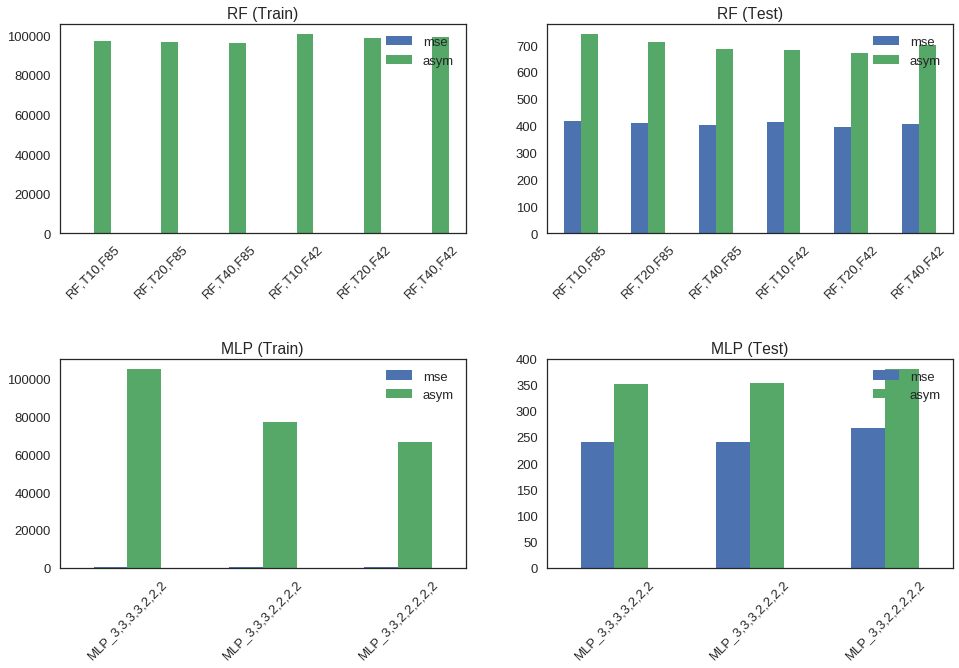

In [21]:
_, axes = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.6)
for i in range(2):
    for j in range(2):
        vis_by_bar(result_grid[i][j], title=title_grid[i][j], **{'ax': axes[i,j], 'figsize': (16,10), 'rot': 45})

### Manipulation for (True, Pred) Scatter Plots

In [22]:
train_true_list = [rf_y_train, mlp_y_train]
train_pred_list = [rf_train_pred, mlp_train_pred]

test_true_list = [rf_y_test, mlp_y_test]
test_pred_list = [rf_test_pred, mlp_test_pred]

train_vals = [rf_train, mlp_train]
test_vals = [rf_test, mlp_test]

all_model_name_list = [rf_model_names, mlp_model_names]

### Scatter Plot for Training

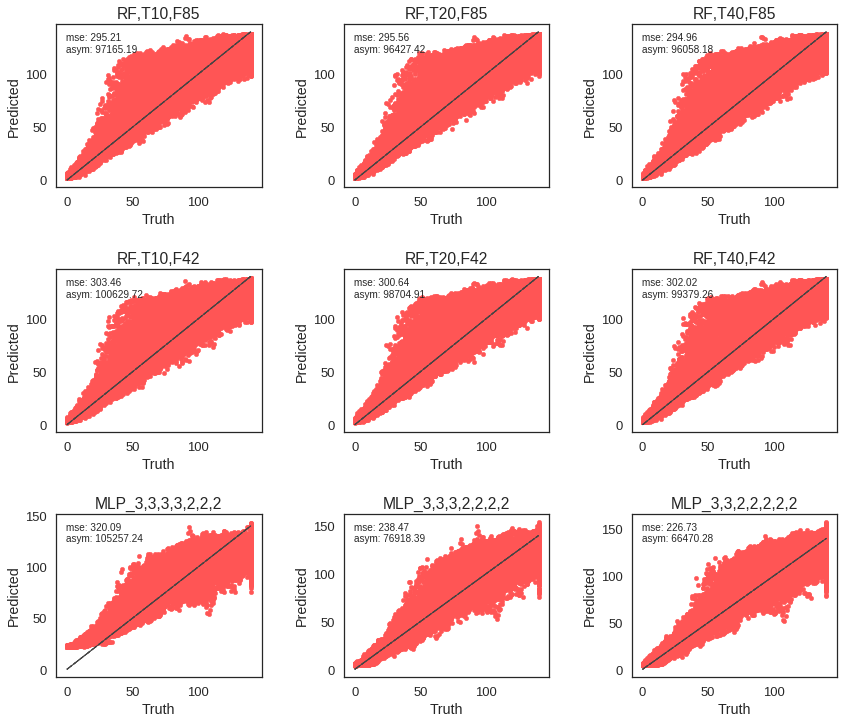

In [23]:
vis_by_scatter(train_true_list, train_pred_list, vals=train_vals, model_name_list=all_model_name_list, 
               grid_size=(3,3), margins=(0.4,0.5), fig_size=(14,12))

### Scatter Plot for Testing

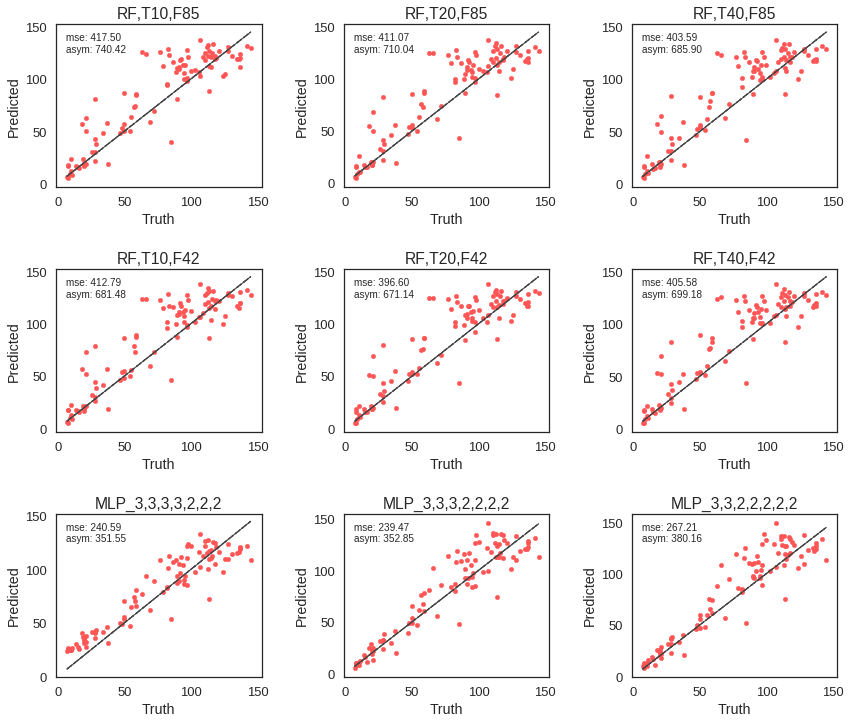

In [24]:
vis_by_scatter(test_true_list, test_pred_list, vals=test_vals, model_name_list=all_model_name_list, 
               grid_size=(3,3), margins=(0.4,0.5), fig_size=(14,12))

In [ ]:
# os.system('say "Code Finishes Bbagayaro"')
# os.system('say "코드 다 돌았어 이놈시끼야"')
# os.system('say "your program has finished"') 

---

## To-do

1. ~~Testing several models for a given fraction~~
1. Plotting for one fraction
    - Bar plot to compare models on MSE and Asym loss
    - Scatter plot of true vs. pred for each model (train/test)
        - MSE as text label
        - Asym loss as text label
1. Modulurize the process above to run for every fraction

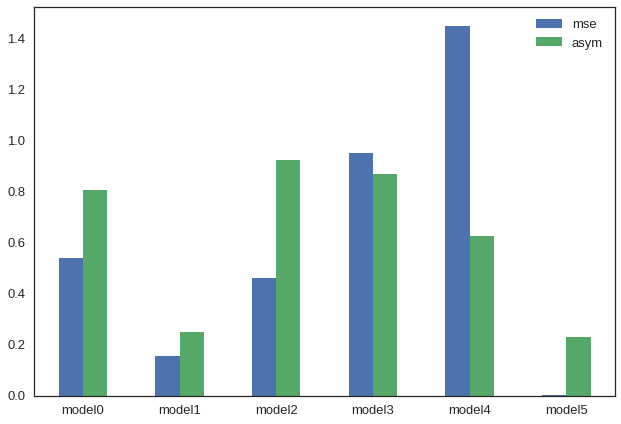

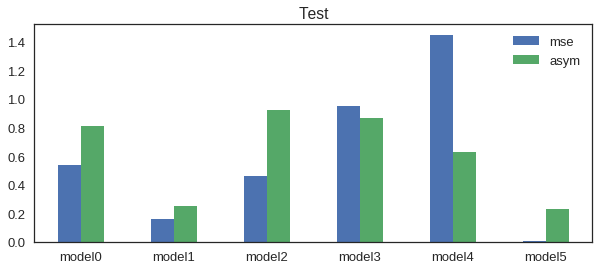

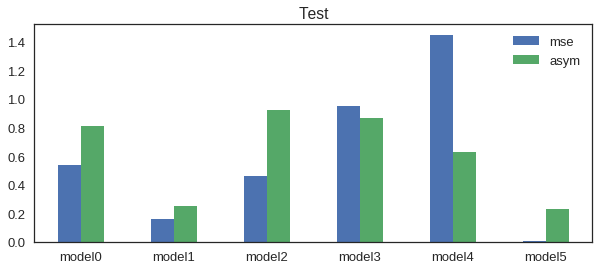

In [39]:
# # 2. toy example of bar plot
# model_names = ['model' + str(i) for i in range(6)]
# losses = np.abs(np.random.randn(len(model_names), 2))
# eval_df = pd.DataFrame(losses, index=model_names, columns=['mse', 'asym'])
# eval_df.plot.bar(rot=0)

# def vis_with_bar(vals, model_names=None, metric_names=None, title=None, ax=None, rot=0):
#     """
#     Rows of vals correspond to models
#     Columns of vals correspond to metrics
#     """
#     if type(vals) is not pd.DataFrame:
#         eval_df = pd.DataFrame(vals, index=model_names, columns=['mse', 'asym'])
#     else:
#         eval_df = vals
    
#     eval_df.plot.bar(ax=ax, rot=rot, figsize=(10,4), title=title)
    
# vis_with_bar(losses, model_names, ['mse', 'asym'], title='Test')
# vis_with_bar(eval_df, title='Test')

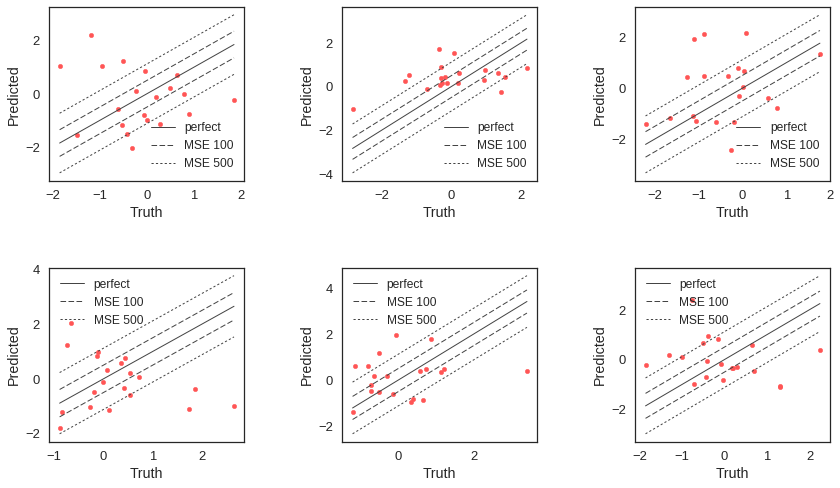

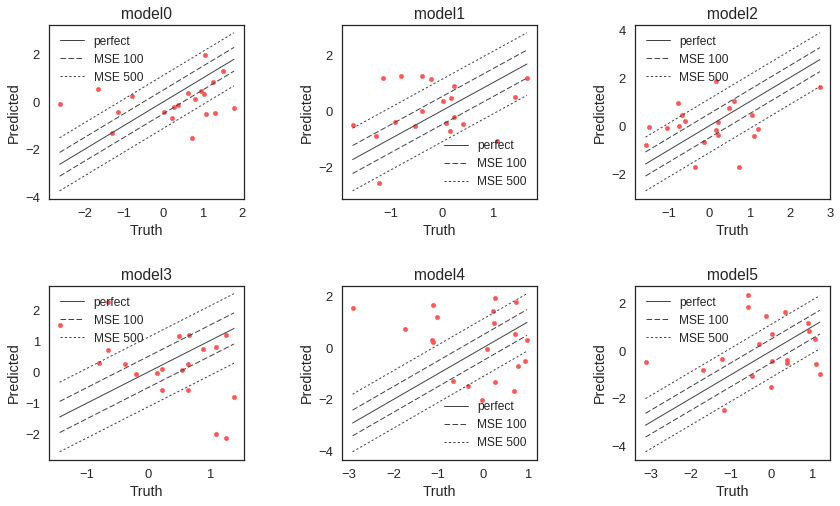

In [104]:
# n_instances = 20

# fig, axes = plt.subplots(nrows=2, ncols=3)
# plt.subplots_adjust(wspace=0.5, hspace=0.5)
# for i, model_name in enumerate(model_names):
#     # synthetic values
#     y_true = np.random.randn(n_instances)
#     y_pred = np.random.randn(n_instances)
    
#     lim = np.min(y_true), np.max(y_true)
    
#     # perfect line
#     ax = axes.flatten()[i]
#     ax.plot(lim, lim, '-', color='#444444', linewidth=1, label='perfect')
#     ax.margins(x=0.05, y=0.05, tight=False)
    
#     # error line
#     guide_mses = [100, 500]
#     guide_mse_styles = ['--', ':']
#     for g, ls in zip(guide_mses, guide_mse_styles):
#         ax.plot(lim, lim + np.sqrt(g)/n_instances, linestyle=ls, color='#444444', linewidth=1, label='MSE {}'.format(g))
#         ax.plot(lim, lim - np.sqrt(g)/n_instances, linestyle=ls, color='#444444', linewidth=1)
    
#     # true vs. pred
#     vs_df = pd.DataFrame(np.array([y_true,y_pred]).T, columns=['Truth', 'Predicted'])
#     vs_df.plot.scatter(x='Truth', y='Predicted', ax=ax, figsize=(14,8), c='#FF5555')

#     ax.legend(prop={'size':12})
    
# def vis_as_scatter(y_true_mat, y_pred_mat, model_names, grid_size):
#     n_instances = y_true_mat.shape[0]

#     _, axes = plt.subplots(nrows=grid_size[0], ncols=grid_size[1])
#     plt.subplots_adjust(wspace=0.5, hspace=0.5)
#     for i, model_name in enumerate(model_names):
#         # synthetic values
#         y_true = y_true_mat[:, i]
#         y_pred = y_pred_mat[:, i]

#         lim = np.min(y_true), np.max(y_true)

#         # perfect line
#         ax = axes.flatten()[i]
#         ax.plot(lim, lim, '-', color='#444444', linewidth=1, label='perfect')
#         ax.margins(x=0.05, y=0.05, tight=False)

#         # error line
#         guide_mses = [100, 500]
#         guide_mse_styles = ['--', ':']
#         for g, ls in zip(guide_mses, guide_mse_styles):
#             ax.plot(lim, lim + np.sqrt(g)/n_instances, linestyle=ls, color='#444444', linewidth=1, label='MSE {}'.format(g))
#             ax.plot(lim, lim - np.sqrt(g)/n_instances, linestyle=ls, color='#444444', linewidth=1)

#         # true vs. pred
#         vs_df = pd.DataFrame(np.array([y_true,y_pred]).T, columns=['Truth', 'Predicted'])
#         vs_df.plot.scatter(x='Truth', y='Predicted', ax=ax, figsize=(14,8), c='#FF5555', title=model_name)

#         ax.legend(prop={'size':12})
        
# y_true = np.random.randn(n_instances, 6)
# y_pred = np.random.randn(n_instances, 6)
# model_names = ['model'+str(i) for i in range(6)]
# vis_as_scatter(y_true, y_pred, model_names, (2,3))